In [1]:
from IPython.core.display import HTML 

# Introduction to MongoDB with PyMongo and NOAA Data

This notebook provides a basic walkthrough of how to use MongoDB and is based on a tutorial originally by [Alberto Negron](http://altons.github.io/python/2013/01/21/gentle-introduction-to-mongodb-using-pymongo/).

Metadata records are frequently stored as JSON, and almost anything you get from an API will be JSON. For example, check out the [metadata records](https://data.noaa.gov/data.json) for the National Oceanic and Atmospheric Administration. 

MongoDB is a great tool to use with JSON data because it stores structured data as JSON-like documents, using dynamic schemas (called BSON), rather than predefined schemas. 

In MongoDB, an element of data is called a document, and documents are stored in collections. One collection may have any number of documents. Collections are a bit like tables in a relational database, and documents are like records. But there is one big difference: every record in a table has the same fields (with, usually, differing values) in the same order, while each document in a collection can have completely different fields from the other documents.

Documents are Python dictionaries that can have strings as keys and can contain various primitive types (int, float,unicode, datetime) as well as other documents (Python dicts) and arrays (Python lists).

## Getting started
First we need to import `json` and `pymongo`.

Note that the `pprint` module provides a capability to “pretty-print” arbitrary Python data structures in a form which can be used as input to the interpreter. This is particularly helpful with JSON. You can read more about `pprint` [here](https://docs.python.org/2/library/pprint.html).

In [2]:
import json
import pymongo
from pprint import pprint

## Connect    
Just as with the relational database example with `sqlite`, we need to begin by setting up a connection. With MongoDB, we will be using `pymongo`, though MongoDB also comes with a [console API that uses Javascript](https://docs.mongodb.org/manual/tutorial/write-scripts-for-the-mongo-shell/).    


To make our connection, we will use the PyMongo method `MongoClient`:

In [3]:
conn=pymongo.MongoClient()
conn

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

## Create and access a database    
Mongodb creates databases and collections automatically for you if they don't exist already. A single instance of MongoDB can support multiple independent databases. When working with PyMongo, we access databases using attribute style access, just like we did with `sqlite`:

In [4]:
db = conn.mydb
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'mydb')

## Collections    
A collection is a group of documents stored in MongoDB, and can be thought of as roughly the equivalent of a table in a relational database. Getting a collection in PyMongo works the same as getting a database:

In [5]:
collection = db.my_collection
collection

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'mydb'), u'my_collection')

## Insert data   
To insert some data into MongoDB, all we need to do is create a dict and call `insert_one` on the collection object:

In [6]:
doc = {"class":"XBUS-502","date":"03-05-2016","instructor":"Bengfort","classroom":"C222","roster_count":"25"}
collection.insert_one(doc)

In [7]:
conn.database_names()

[u'local', u'mydb']

In [8]:
db.collection_names()

[u'my_collection', u'system.indexes']

## A practical example

Let's say you wanted to gather up a bunch of JSON metadata records and store them for analysis. 

```python
import requests

NOAA_URL = "https://data.noaa.gov/data.json"

def load_data(URL):
    """
    Loads the data from URL and returns data in JSON format.
    """
    r = requests.get(URL)
    data = r.json()
    return data
    
noaa = load_data(NOAA_URL)
```

This takes a long time, so I've created a file for you that contains a small chunk of the records to use for today's workshop.

In [9]:
with open("data_sample.json") as data_file:    
    noaa = json.load(data_file)

In [10]:
len(noaa)

1722

### Checking out the data
Now let's print out just one record to examine the structure. 

In [12]:
pprint(noaa[0])

{u'@type': u'dcat:Dataset',
 u'accessLevel': u'public',
 u'accrualPeriodicity': u'irregular',
 u'bureauCode': [u'006:48'],
 u'contactPoint': {u'@type': u'vcard:Contact',
                   u'fn': u'Ilya P. Romanov',
                   u'hasEmail': u'mailto:nsidc@nsidc.org'},
 u'description': u"This data set contains sea ice and snow measurements collected during aircraft landings associated with the Soviet Union's historical Sever airborne and North Pole drifting station programs. The High-Latitude Airborne Annual Expeditions Sever (Sever means North) took place in 1937, 1941, 1948-1952, and 1954-1993 (Konstantinov and Grachev, 2000). In Spring 1993, the last (45th) Sever expedition finished long-term activity in the Arctic. Snow and sea ice data were collected, along with meteorological and hydrological measurements (the latter are not part of this data set). Up to 202 landings were accomplished each year.  The data set contains measurements of 23 parameters, including ice thickness a

Or say we wanted just the "description" field:

In [13]:
pprint(noaa[0]['description'])

u"This data set contains sea ice and snow measurements collected during aircraft landings associated with the Soviet Union's historical Sever airborne and North Pole drifting station programs. The High-Latitude Airborne Annual Expeditions Sever (Sever means North) took place in 1937, 1941, 1948-1952, and 1954-1993 (Konstantinov and Grachev, 2000). In Spring 1993, the last (45th) Sever expedition finished long-term activity in the Arctic. Snow and sea ice data were collected, along with meteorological and hydrological measurements (the latter are not part of this data set). Up to 202 landings were accomplished each year.  The data set contains measurements of 23 parameters, including ice thickness and snow depth on the runway and surrounding area; ridge, hummock, and sastrugi dimensions and areal coverage; and snow density. The sea ice thickness data are of particular importance, as ice thickness measurements for the Arctic Basin are scarce. These data are a subset of those used to crea

### Define the database
We will want to enter these records into our database. But first, we'll define a specific database for the NOAA records:

In [14]:
db = conn.earthwindfire

### Define the collection
Next we define the collection where we'll insert the NOAA metadata records:

In [15]:
records = db.records

### Insert data    
Then we loop through each record in the NOAA dataset and insert just the target information for each into the collection:

In [16]:
def insert(metadata):
    for dataset in metadata:
        data ={}
        data["title"] = dataset["title"]
        data["description"] = dataset["description"]
        data["keywords"] = dataset["keyword"]
        data["accessLevel"] = dataset["accessLevel"]
        # choose your own
        # choose your own
        # choose your own 
        # choose your own

        records.insert_one(data)

insert(noaa)

In [17]:
records.count()

1722

### Querying 

#### Querying with `.findOne( )`    
The find_one() method selects and returns a single document from a collection and returns that document (or None if there are no matches). It is useful when you know there is only one matching document, or are only interested in the first match

In [18]:
records.find_one()

{u'_id': ObjectId('56d8e4a8be18b1170f75881d'),
 u'accessLevel': u'public',
 u'description': u"This data set contains sea ice and snow measurements collected during aircraft landings associated with the Soviet Union's historical Sever airborne and North Pole drifting station programs. The High-Latitude Airborne Annual Expeditions Sever (Sever means North) took place in 1937, 1941, 1948-1952, and 1954-1993 (Konstantinov and Grachev, 2000). In Spring 1993, the last (45th) Sever expedition finished long-term activity in the Arctic. Snow and sea ice data were collected, along with meteorological and hydrological measurements (the latter are not part of this data set). Up to 202 landings were accomplished each year.  The data set contains measurements of 23 parameters, including ice thickness and snow depth on the runway and surrounding area; ridge, hummock, and sastrugi dimensions and areal coverage; and snow density. The sea ice thickness data are of particular importance, as ice thickness

#### Querying with `.find( )`
To get more than a single document as the result of a query we use the `find()` method. `find()` returns a Cursor instance, which allows us to iterate over all matching documents.

```python
records.find()
```

For example, we can iterate over the first 2 documents (there are a lot in the collection and this is just an example) in the records collection

In [19]:
for rec in records.find()[:2]:
    pprint(rec)

{u'_id': ObjectId('56d8e4a8be18b1170f75881d'),
 u'accessLevel': u'public',
 u'description': u"This data set contains sea ice and snow measurements collected during aircraft landings associated with the Soviet Union's historical Sever airborne and North Pole drifting station programs. The High-Latitude Airborne Annual Expeditions Sever (Sever means North) took place in 1937, 1941, 1948-1952, and 1954-1993 (Konstantinov and Grachev, 2000). In Spring 1993, the last (45th) Sever expedition finished long-term activity in the Arctic. Snow and sea ice data were collected, along with meteorological and hydrological measurements (the latter are not part of this data set). Up to 202 landings were accomplished each year.  The data set contains measurements of 23 parameters, including ice thickness and snow depth on the runway and surrounding area; ridge, hummock, and sastrugi dimensions and areal coverage; and snow density. The sea ice thickness data are of particular importance, as ice thickness

#### Searching 
MongoDB queries are represented as JSON-like structures just like documents. To build a query, you just need to specify a dictionary with the properties you want the results to match. For example, let's say we were just interested in publically available satellite data from [NESDIS](http://www.nesdis.noaa.gov/).

This query will match all documents in the records collection with keywords code "NESDIS".

In [20]:
records.find({"keywords": "NESDIS"}).count()

1117

1117 is probably more than we want to print out in a Jupyter Notebook...    

We can further narrow our search by adding additional fields

In [22]:
records.find({"keywords": "NESDIS","keywords": "Russia","accessLevel":"public"}).count()

2

Since there's only two, let's check them out:

In [25]:
for r in records.find({"keywords": "NESDIS","keywords": "Russia","accessLevel":"public"}):
    pprint(r)

{u'_id': ObjectId('56d8e4a8be18b1170f75881e'),
 u'accessLevel': u'public',
 u'description': u'This data set was distributed by NSIDC until October, 2003, when it was withdrawn from distribution because it duplicates the NOAA National Climatic Data Center (NCDC) data set DSI-3720. The NCDC data set is revised and updated beyond what was distributed by NSIDC. This archive consists of monthly precipitation measurements from 622 stations located in the Former Soviet Union.',
 u'keywords': [u'Continent > Europe > Eastern Europe > Russia',
               u'EARTH SCIENCE > Atmosphere > Precipitation > Precipitation Amount',
               u'EARTH SCIENCE > Atmosphere > Precipitation > Precipitation Rate',
               u'EARTH SCIENCE > Atmosphere > Precipitation > Rain',
               u'EARTH SCIENCE > Atmosphere > Precipitation > Snow',
               u'EARTH SCIENCE > Terrestrial Hydrosphere > Snow/Ice > Snow Cover',
               u'EOSDIS > Earth Observing System Data Information Syste

### Statistics    

The [`dbstats`](https://docs.mongodb.org/manual/reference/method/db.stats/) method returns statistics that reflect the use state of a single database:

In [26]:
db.command({'dbstats': 1})

{u'avgObjSize': 2235.0869061413673,
 u'collections': 3,
 u'dataFileVersion': {u'major': 4, u'minor': 22},
 u'dataSize': 3857760.0,
 u'db': u'earthwindfire',
 u'extentFreeList': {u'num': 0, u'totalSize': 0},
 u'fileSize': 67108864.0,
 u'indexSize': 65408.0,
 u'indexes': 1,
 u'nsSizeMB': 16,
 u'numExtents': 8,
 u'objects': 1726,
 u'ok': 1.0,
 u'storageSize': 11194368.0}

[`collStats`](https://docs.mongodb.org/manual/reference/command/collStats/) returns a variety of storage statistics for a given collection. Let's try it out for our NOAA records collection:

In [27]:
db.command({'collstats': 'records', 'verbose': 'true' })

{u'avgObjSize': 2240,
 u'capped': False,
 u'count': 1722,
 u'extents': [{u'len': 8192, u'loc: ': {u'file': 0, u'offset': 20480}},
  {u'len': 32768, u'loc: ': {u'file': 0, u'offset': 167936}},
  {u'len': 131072, u'loc: ': {u'file': 0, u'offset': 200704}},
  {u'len': 524288, u'loc: ': {u'file': 0, u'offset': 331776}},
  {u'len': 2097152, u'loc: ': {u'file': 0, u'offset': 856064}},
  {u'len': 8388608, u'loc: ': {u'file': 0, u'offset': 2953216}}],
 u'indexDetails': {},
 u'indexSizes': {u'_id_': 65408},
 u'lastExtentSize': 8388608.0,
 u'nindexes': 1,
 u'ns': u'earthwindfire.records',
 u'numExtents': 6,
 u'ok': 1.0,
 u'paddingFactor': 1.0,
 u'paddingFactorNote': u'paddingFactor is unused and unmaintained in 3.0. It remains hard coded to 1.0 for compatibility only.',
 u'size': 3857504,
 u'storageSize': 11182080,
 u'totalIndexSize': 65408,
 u'userFlags': 1}

### The aggregation pipeline 

The [aggregation pipeline](https://docs.mongodb.org/manual/core/aggregation-pipeline/) allows MongoDB to provide native aggregation capabilities that corresponds to many common data aggregation operations in SQL.

The following table provides an overview of common SQL aggregation terms, functions, and concepts and the corresponding MongoDB aggregation operators:    
    
| SQL Terms, Functions, and Concepts  | MongoDB Aggregation Operators  |
| ----------------------------------  |:-------------------------------|
| WHERE                               | \$match                        |
| GROUP BY                            | \$group                        |
| HAVING                              | \$match                        |
| SELECT	                          | \$project                      |
| ORDER BY	                          | \$sort                         |
| LIMIT                               | \$limit                        |
| SUM()   	                          | \$sum                          |
| COUNT()	                          | \$sum                          |
| join	                              | \$lookup                       |

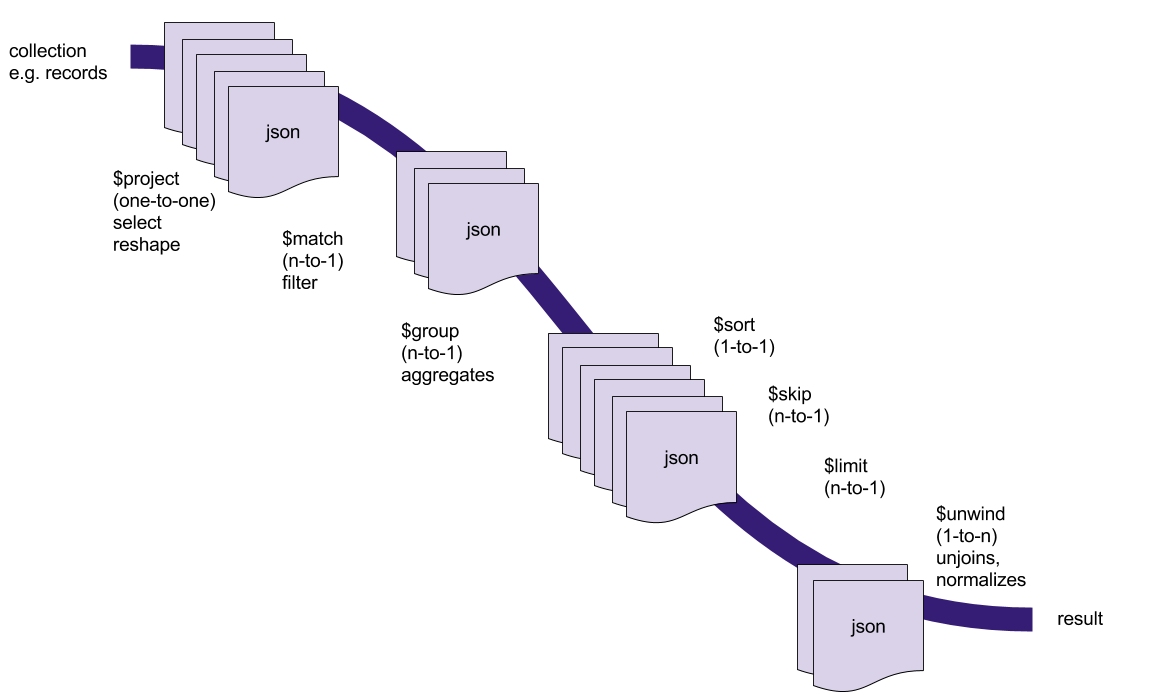

In [28]:
from IPython.display import Image
Image(filename='images/mongodb_pipeline.png', width=600, height=300)

### Removing data    

It's easy (almost too easy) to delete projects, collections, and databases in MongoDB. Before we get rid of anything, let's determine what collections we have in our database:

In [29]:
conn.earthwindfire.collection_names()

[u'records', u'system.indexes']

Now let's delete our records collection and check again to see what collections are in our database:

In [30]:
conn.earthwindfire.drop_collection("records")
conn.earthwindfire.collection_names()

[u'system.indexes']

We can also just drop a database. First let's determine what databases we have:

In [31]:
conn.database_names()

[u'earthwindfire', u'local', u'mydb']

Now let's remove the earthwindfire database:

In [32]:
conn.drop_database("earthwindfire")
conn.database_names()

[u'local', u'mydb']

Nice work!